In [1]:
import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from scipy.stats import linregress
from pprint import pprint
from citipy import citipy
from api_keys import weather_api_key
from api_keys import g_key

ModuleNotFoundError: No module named 'citipy'

In [ ]:
# Construct city list from the jason file that is distributed by api.openweather.org, save the list to "allcities.csv"

with open('city.list.json', 'r',encoding='utf-8') as jsonfile:
    jsndata = json.load(jsonfile)

ids = []
nam = []
country = []
lat = []
lon = []

for i in range(len(jsndata)):
    ids.append(jsndata[i]['id'])
    nam.append(jsndata[i]['name'].lower())
    country.append(jsndata[i]['country'])
    # need to lower the letter case because citipy uses lower case letters
    lat.append(jsndata[i]['coord']['lat'])
    lon.append(jsndata[i]['coord']['lon'])
    
dftemp = pd.DataFrame({'id':ids,'City':nam,'Country':country,'Lat':lat,'Lng':lon})
dftemp.to_csv("output_data/allcities.csv", index=False, header=True)

In [ ]:
# Read dfcities.csv file into dataframe, previous cell is not required to run once the dfcities.csv is saved

dfcities = pd.read_csv("output_data/allcities.csv", encoding="utf-8")
dfcities = dfcities.set_index('City')
dfcities.head()

In [2]:
# Select 500 unique cities and save the data into dfselected.csv

ncities = 500
namsel = []
idsel = []
countrysel = []
latsel = []
lonsel = []
i = 0
while(i < ncities):
    i = i+1
    latitude = random.uniform(-90.0,90.0)
    longitude = random.uniform(-180.0,180.0)
    city = citipy.nearest_city(latitude,longitude)
    try:
        id = int(dfcities.loc[city.city_name]['id'])
        try:
            itemp = idsel.index(id)
            i = i - 1
        except:
            idsel.append(id)
            namsel.append(city.city_name)
            countrysel.append(dfcities.loc[city.city_name]['Country'])
            latsel.append(dfcities.loc[city.city_name]['Lat'])
            lonsel.append(dfcities.loc[city.city_name]['Lng'])
    except:
        i = i - 1

dftemp = pd.DataFrame({'City':namsel,'id':idsel,'Country':countrysel,'Lat':latsel,'Lng':lonsel})
dftemp.to_csv("output_data/dfselected.csv", index=False, header=True)

NameError: name 'citipy' is not defined

500
                   City       id Country        Lat         Lng
0          punta arenas  3874787      CL -53.150002  -70.916672
1            chokurdakh  2126123      RU  70.633331  147.916672
2            marienburg  3383570      SR   5.846910  -55.021591
3  bernardino de campos  3470059      BR -23.013060  -49.474171
4                yantal  2055868      RU  56.847099  105.254204


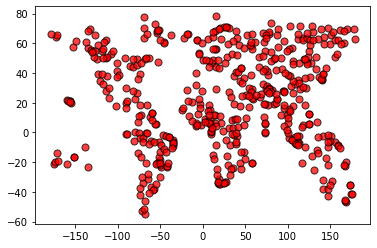

In [3]:
# Read dfselected.csv file into dataframe, previous cells are not required to run once the dfselected.csv is saved
# generate scatter plot to make sure that cities are distributed throughout the globe

dfselected = pd.read_csv("output_data/dfselected.csv", encoding="utf-8")

# print total # of selected cities
print(len(dfselected)) 

# check if the dataframe has the right format
print(dfselected.head())

# generate the scatter plot to make sure that the cities are evenly distributed throughout the globe
plt.scatter(dfselected["Lng"],dfselected["Lat"],marker="o",facecolors="red",edgecolors="black",s=50,alpha=0.75)

In [4]:
# Request weather informatiton for the selected cities and save into a json file weatherlist.json

jsnlist = []

i = 0
waitingtime = 0
ncities = len(dfselected)
while i < ncities:
    id = dfselected['id'][i]
    url = f"http://api.openweathermap.org/data/2.5/forecast?id={id}&units=imperial&APPID={weather_api_key}"
    jsn = requests.get(url).json()
    try:
        print('City-{0}: {1}'.format(i,jsn['city']['name']))
        jsnlist.append(jsn)
        i = i + 1
        waitingtime = 0
    except:
        waitingtime = waitingtime + 1
        print(f"Waiting {waitingtime} seconds")
        time.sleep(1)
    
with open('output_data/weatherlist.json', 'w') as jsonfile:
    json.dump(jsnlist, jsonfile)

NameError: name 'weather_api_key' is not defined

In [5]:
# Read weatherlist.json and dfselected.csv and create cities.csv

with open('output_data/weatherlist.json', 'r',encoding='utf-8') as jsonfile:
    weatherlist = json.load(jsonfile)

# Read again the selected cities just in case if the notebook is opened again
cities = pd.read_csv("output_data/dfselected.csv", encoding="utf-8")
del cities['id']

cities['Date'] = [weatherlist[i]['list'][0]['dt'] for i in range(len(weatherlist))]
cities['Cloudiness'] = [weatherlist[i]['list'][0]['clouds']['all'] for i in range(len(weatherlist))]
cities['Humidity'] = [weatherlist[i]['list'][0]['main']['humidity'] for i in range(len(weatherlist))]
cities['Max Temp'] = [weatherlist[i]['list'][0]['main']['temp_max'] for i in range(len(weatherlist))]
cities['Wind Speed'] = [weatherlist[i]['list'][0]['wind']['speed'] for i in range(len(weatherlist))]

# Save the result into cities.csv file
cities.to_csv("output_data/cities.csv", index=False, header=True)

In [6]:
# read the cities.csv to create dataframe, previous cells are not needed to be executed as long as cities.csv was created

cities = pd.read_csv("output_data/cities.csv", encoding="utf-8")
cities.head()

,City,Country,Lat,Lng,Date,Cloudiness,Humidity,Max Temp,Wind Speed
0,punta arenas,CL,-53.150002,-70.916672,1569207600,90,84,43.97,11.34
1,chokurdakh,RU,70.633331,147.916672,1569207600,0,61,36.52,9.82
2,marienburg,SR,5.846910,-55.021591,1569207600,58,82,82.31,19.17
3,bernardino de campos,BR,-23.013060,-49.474171,1569207600,60,70,59.09,19.77
4,yantal,RU,56.847099,105.254204,1569207600,87,62,62.47,4.68


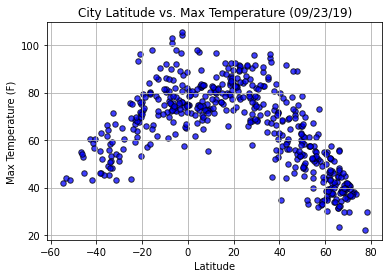

In [7]:
# import time
# convert datetime to 10 digit value
# my_time = time.strptime("09/22/19", "%m/%d/%y")
# timevalue = time.mktime(my_time)
# print(timevalue)

ts = time.gmtime(cities['Date'][0])
# print(time.strftime("%m/%d/%Y %H:%M:%S", ts))
datestr = time.strftime("%x",ts)
plt.scatter(cities['Lat'],cities['Max Temp'], marker="o", facecolors="blue", edgecolors="black",s=30, alpha=0.75)
plt.grid()
plt.title(f"City Latitude vs. Max Temperature ({datestr})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig("output_data/fig1.png")
plt.show()

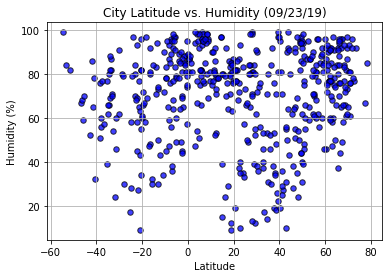

In [8]:
ts = time.gmtime(cities['Date'][0])
datestr = time.strftime("%x",ts)
plt.scatter(cities['Lat'],cities['Humidity'], marker="o", facecolors="blue", edgecolors="black",s=30, alpha=0.75)
plt.grid()
plt.title(f"City Latitude vs. Humidity ({datestr})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig("output_data/fig2.png")
plt.show()

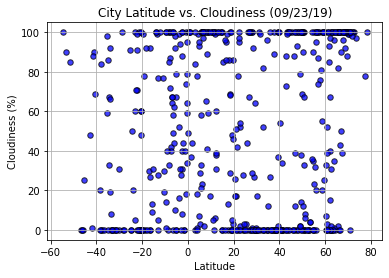

In [9]:
ts = time.gmtime(cities['Date'][0])
datestr = time.strftime("%x",ts)
plt.scatter(cities['Lat'],cities['Cloudiness'], marker="o", facecolors="blue", edgecolors="black",s=30, alpha=0.75)
plt.grid()
plt.title(f"City Latitude vs. Cloudiness ({datestr})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig("output_data/fig3.png")
plt.show()

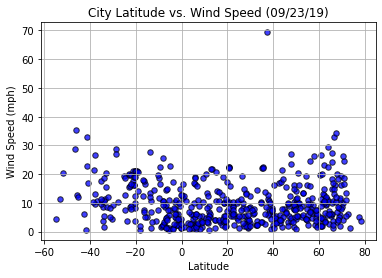

In [10]:
ts = time.gmtime(cities['Date'][0])
datestr = time.strftime("%x",ts)
plt.scatter(cities['Lat'],cities['Wind Speed'], marker="o", facecolors="blue", edgecolors="black",s=30, alpha=0.75)
plt.grid()
plt.title(f"City Latitude vs. Wind Speed ({datestr})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig("output_data/fig4.png")
plt.show()

In [13]:
nothern = cities.loc[cities["Lat"] >= 0.0]
nothern.reset_index(inplace=True)

southern = cities.loc[cities["Lat"] < 0.0]
southern.reset_index(inplace=True)

In [14]:
# Define plotting function

def plotLinearRegression(xdata,ydata,xlbl,ylbl,lblpos,ifig):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xdata, ydata)
    print(f"The r-squared is: {rvalue}")
    regress_values = xdata * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    plt.scatter(xdata,ydata)
    plt.plot(xdata,regress_values,"r-")
    plt.annotate(line_eq,lblpos,fontsize=15,color="red")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.savefig(f"output_data/fig{ifig}.png")
    plt.show()

The r-squared is: -0.8162328591308727


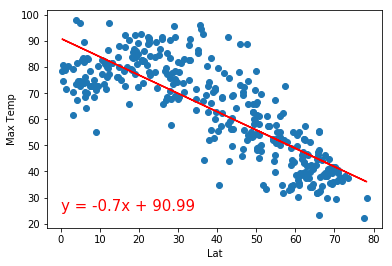

In [15]:
# Northern Hemisphere - Max Temp vs. Latitude Linear Regression

xlbl = "Lat"
ylbl = "Max Temp"
lblpos = (0,25)
plotLinearRegression(nothern[xlbl],nothern[ylbl],xlbl,ylbl,lblpos,5)

The r-squared is: 0.7122172176566883


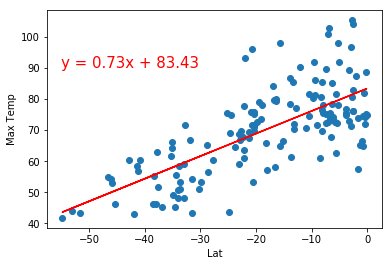

In [16]:
# Northern Hemisphere - Max Temp vs. Latitude Linear Regression

xlbl = "Lat"
ylbl = "Max Temp"
lblpos = (-55,90)
plotLinearRegression(southern[xlbl],southern[ylbl],xlbl,ylbl,lblpos,6)

The r-squared is: 0.015825572899049192


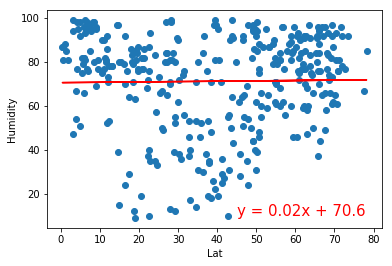

In [17]:
# Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
xlbl = "Lat"
ylbl = "Humidity"
lblpos = (45,10)
plotLinearRegression(nothern[xlbl],nothern[ylbl],xlbl,ylbl,lblpos,7)

The r-squared is: 0.15962027604912832


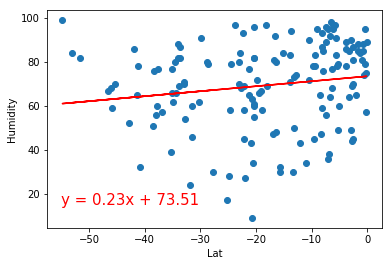

In [18]:
# Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
xlbl = "Lat"
ylbl = "Humidity"
lblpos = (-55,15)
plotLinearRegression(southern[xlbl],southern[ylbl],xlbl,ylbl,lblpos,8)

The r-squared is: 0.10204366115378848


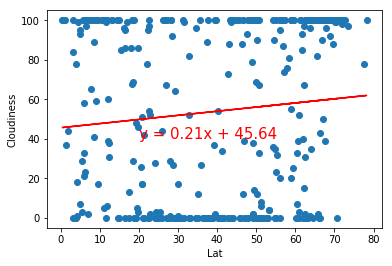

In [19]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
xlbl = "Lat"
ylbl = "Cloudiness"
lblpos = (20,40)
plotLinearRegression(nothern[xlbl],nothern[ylbl],xlbl,ylbl,lblpos,9)

The r-squared is: 0.16872956866693228


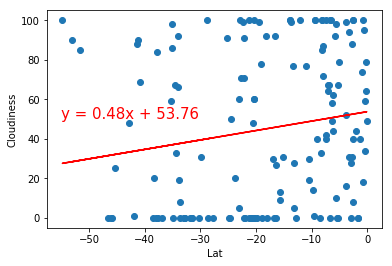

In [20]:
# Sourhern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
xlbl = "Lat"
ylbl = "Cloudiness"
lblpos = (-55,50)
plotLinearRegression(southern[xlbl],southern[ylbl],xlbl,ylbl,lblpos,10)

The r-squared is: 0.16378304462231275


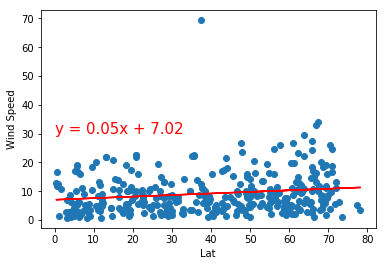

In [21]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

xlbl = "Lat"
ylbl = "Wind Speed"
lblpos = (0,30)
plotLinearRegression(nothern[xlbl],nothern[ylbl],xlbl,ylbl,lblpos,11)

The r-squared is: -0.38921268213200955


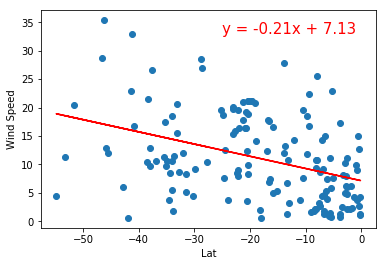

In [22]:
# Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
xlbl = "Lat"
ylbl = "Wind Speed"
lblpos = (-25,33)
plotLinearRegression(southern[xlbl],southern[ylbl],xlbl,ylbl,lblpos,12)

# Observations
1. As expected, temperature correlates well with the latitude. As latitude moves away from equator, temperature also decreases
2. It seems that there is no correlation between humidity and latitude
3. Even though there is very little correlation between wind speed and latitude, wind speed tends to be higher near arctic and antarctic